# Formula 1 Development Analysis: Impact of ATR Regulations
**Project Objective:** Modelling how Aerodynamic Testing Restrictions (ATR) and Cost Cap regulations which was implemented after the year 2019 affects the competition, pure car performances(qualifying lap times), in season development rates to predict future performance trends in the sport using Machine Learning.

### Methodology
1. **Data Collection:** Taking the data of qualifying sessions from 2017 to 2024
2. **Preprocessing:** Converting lap times to seconds and filtering out wet sessions(filtering environmental noise) to isolate aerodynamic performance.
3. **EDA (Exploratory Data Analysis):** Visualizing the "Gap to Pole" percentage trends to understand the data.
4. **Mathematical Modeling:** Using statistical methods to quantifyin the effect of the regulations and performance trends.
5. **Machine Learning:** Using Linear regression to analyze Feature Importance and predict 2025 development trends.

**DATA COLLECTION**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from scipy.stats import linregress
from scipy.stats import  levene
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 12
    
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [2]:
#Function for changing the time format to total seconds for calculations
def time_to_seconds(time_str):
    try:
        if pd.isna(time_str) or str(time_str).strip() == '': return np.nan
        parts = str(time_str).split(':')
        if len(parts) == 2:
            return float(parts[0]) * 60 + float(parts[1])
        return float(parts[0])
    except:
        return np.nan


cleaning the data

In [3]:
# eliminating the rainy qualifying sessions since they are not a representative of the pure aerodynamic performance and would create noise in the analysis.(In Formula 1 rainy sessions generally lead to unpredictable results as driver skill and external factors play a larger role than car aerodynamics)
WET_QUALIFYING_SESSIONS = [
    (2017, 'Italian Grand Prix'),
    (2018, 'Hungarian Grand Prix'), (2018, 'Belgian Grand Prix'), (2018, 'Japanese Grand Prix'),
    (2019, 'German Grand Prix'),
    (2020, 'Styrian Grand Prix'), (2020, 'Turkish Grand Prix'),
    (2021, 'Emilia Romagna Grand Prix'), (2021, 'Belgian Grand Prix'), (2021, 'Russian Grand Prix'), (2021, 'Turkish Grand Prix'),
    (2022, 'Emilia Romagna Grand Prix'), (2022, 'Canadian Grand Prix'), (2022, 'British Grand Prix'), (2022, 'Singapore Grand Prix'), (2022, 'Japanese Grand Prix'), (2022, 'São Paulo Grand Prix'),
    (2023, 'Canadian Grand Prix'), (2023, 'British Grand Prix'), (2023, 'Belgian Grand Prix'), (2023, 'Dutch Grand Prix'),
    (2024, 'Chinese Grand Prix'), (2024, 'Canadian Grand Prix'), (2024, 'British Grand Prix')
]
# Manually cleaning data of Logan Sergant since he had an exceptional gap due to a spin in qualifying session which is a  driver error not related to the car.
# This outlier skews the analysis of the car performance therefore will be removed.
DRIVER_OUTLIERS = [
    (2023, 'Saudi Arabian Grand Prix', 858) 
]
# 2020 season is excluded from the analysis due to the significant disruptions caused by the COVID-19 pandemic: Half amount of total races, unpredictable team performances, limited testing opportunities.
EXCLUDED_YEARS = [2020]

In [4]:
try:
    races = pd.read_csv('data/races.csv')
    qualifying = pd.read_csv('data/qualifying.csv')
    constructors = pd.read_csv('data/constructors.csv')
    print("reading is completed ")
except FileNotFoundError:
    print("error: data files not found")

reading is completed 


**PREPROCESSING**

In [5]:
#Changing the format of the data for processing
target_years = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
races = races[races['year'].isin(target_years)][['raceId', 'year', 'name', 'round', 'date']]

df = qualifying.merge(races, on='raceId', how='inner')
df = df.merge(constructors[['constructorId', 'name']], on='constructorId', how='left')
df.rename(columns={'name_y': 'team', 'name_x': 'gp_name'}, inplace=True)
df = df[~df['year'].isin(EXCLUDED_YEARS)]
print(f"After removing 2020 season: {len(df)} sessions")

try:
    con_standings = pd.read_csv('data/constructor_standings.csv')
    con_standings = con_standings.merge(races[['raceId', 'year']], on='raceId', how='inner')
except FileNotFoundError:
    print("Warning: constructor_standings.csv not found!")

print(f"total amount of sessions {len(df)}")
for year, gp_name in WET_QUALIFYING_SESSIONS:
    df = df[~((df['year'] == year) & (df['gp_name'] == gp_name))]

for year, gp_name, driver_id in DRIVER_OUTLIERS:
    df = df[~((df['year'] == year) & (df['gp_name'] == gp_name) & (df['driverId'] == driver_id))]
print(f"After clearing {len(df)}")

df['q1_sec'] = df['q1'].apply(time_to_seconds)
df['q2_sec'] = df['q2'].apply(time_to_seconds)
df['q3_sec'] = df['q3'].apply(time_to_seconds)
df['best_time'] = df[['q1_sec', 'q2_sec', 'q3_sec']].min(axis=1)

df = df.dropna(subset=['best_time'])
df.head()

After removing 2020 season: 3034 sessions
total amount of sessions 3034
After clearing 2593


,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3,year,gp_name,round,date,team,q1_sec,q2_sec,q3_sec,best_time
0,7140,969,1,131,44,1,1:24.191,1:23.251,1:22.188,2017,Australian Grand Prix,1,2017-03-26,Mercedes,84.191,83.251,82.188,82.188
1,7141,969,20,6,5,2,1:25.210,1:23.401,1:22.456,2017,Australian Grand Prix,1,2017-03-26,Ferrari,85.210,83.401,82.456,82.456
2,7142,969,822,131,77,3,1:24.514,1:23.215,1:22.481,2017,Australian Grand Prix,1,2017-03-26,Mercedes,84.514,83.215,82.481,82.481
3,7143,969,8,6,7,4,1:24.352,1:23.376,1:23.033,2017,Australian Grand Prix,1,2017-03-26,Ferrari,84.352,83.376,83.033,83.033
4,7144,969,830,9,33,5,1:24.482,1:24.092,1:23.485,2017,Australian Grand Prix,1,2017-03-26,Red Bull,84.482,84.092,83.485,83.485


standartize team names

In [6]:
# Some teams have changed names over years. We standardize them.

team_mapping = {
    'Force India': 'Aston Martin', 'Racing Point': 'Aston Martin', 'Aston Martin': 'Aston Martin',
    'Sauber': 'Kick Sauber', 'Alfa Romeo': 'Kick Sauber', 'Kick Sauber': 'Kick Sauber',
    'Renault': 'Alpine', 'Alpine': 'Alpine', 'renault': 'Alpine','Alpine F1 Team': 'Alpine',
    'Toro Rosso': 'RB', 'AlphaTauri': 'RB', 'RB': 'RB','RB F1 Team': 'RB',
    'Haas F1 Team': 'Haas', 'Haas': 'Haas',
    'McLaren': 'McLaren',
    'Mercedes': 'Mercedes',
    'Ferrari': 'Ferrari',
    'Red Bull': 'Red Bull',
    'Williams': 'Williams'
}
df['team'] = df['team'].map(team_mapping).fillna(df['team'])

# EXPLORATORY DATA ANALYSIS

To understand the impact of ATR regulations, we examine the competitive landscape through multiple perspectives:
- **Top team performance trends** - How did major teams evolve?
- **Gap distribution evolution** - Is the field getting closer?
- **Team-by-team analysis** - Who improved, who declined?
- **Championship dynamics** - Point margins over time

## 1. Major Teams Performance Trend

The "Big 4" (Mercedes, Ferrari, Red Bull, McLaren) drive F1's competitive dynamics. Analyzing their gap to pole position reveals long-term performance trajectories and the impact of regulation changes.

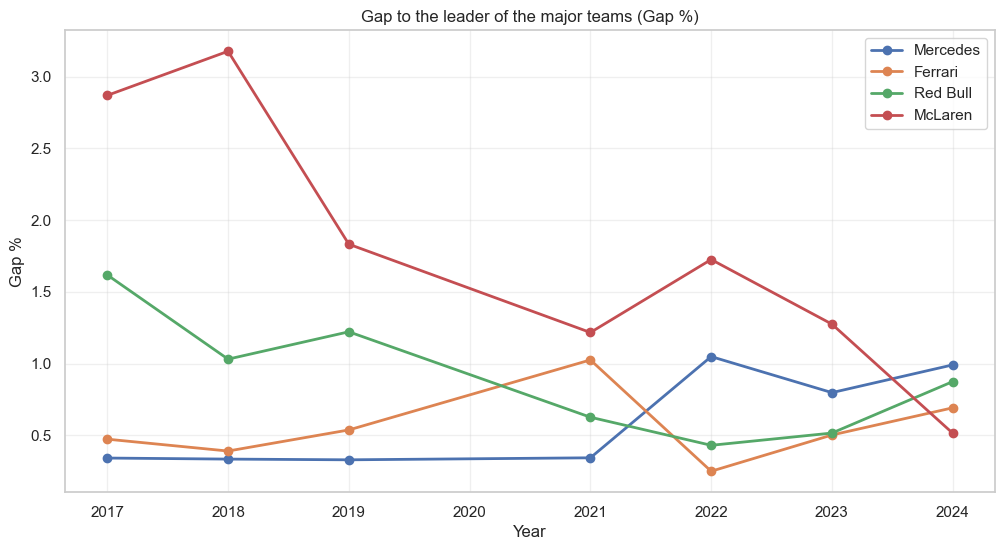

In [7]:

pole_times = df.groupby(['year', 'gp_name'])['best_time'].min().reset_index()
pole_times.rename(columns={'best_time': 'pole_time'}, inplace=True)
df = df.merge(pole_times, on=['year', 'gp_name'], how='left')
df['gap_percent'] = ((df['best_time'] - df['pole_time']) / df['pole_time']) * 100


yearly_stats = df.groupby(['year', 'team'])['gap_percent'].mean().reset_index()

yearly_stats['period'] = yearly_stats['year'].apply(lambda x: 'Pre-ATR (2017-2020)' if x < 2021 else 'Post-ATR (2021-2024)')

top_teams = ['Mercedes', 'Ferrari', 'Red Bull', 'McLaren']
plt.figure(figsize=(12, 6))

for team in top_teams:
    team_data = yearly_stats[yearly_stats['team'] == team]
    plt.plot(team_data['year'], team_data['gap_percent'], marker='o', linewidth=2, label=team)

plt.title("Gap to the leader of the major teams (Gap %)")
plt.ylabel("Gap %")
plt.xlabel("Year")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


**Key Observation:**  
Post-2022 convergence in performance gaps suggests ATR regulations may be achieving their intended effect of leveling the competitive field.

## 2. Field-Wide Gap Distribution Evolution

Ridge plots reveal how the entire field's performance distribution evolved across regulatory eras. Narrower distributions indicate closer competition.

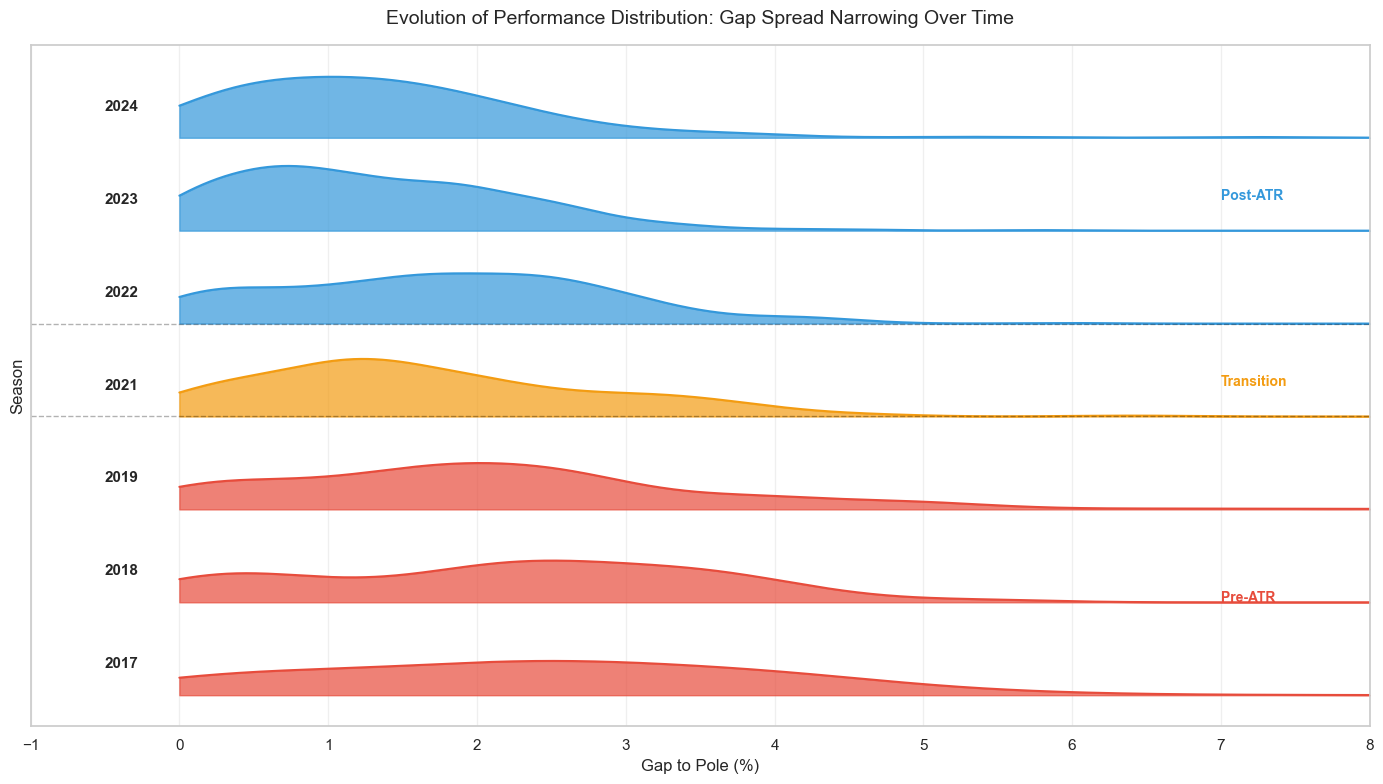


📊 Ridge Plot Interpretation:
• Wider distributions = More spread between teams
• Narrower distributions = Closer competition
• Post-ATR era shows tighter clustering around pole position


In [8]:

ridge_years = [2017, 2018, 2019, 2021, 2022, 2023, 2024]
ridge_data = df[df['year'].isin(ridge_years)].copy()

fig, ax = plt.subplots(figsize=(14, 8))


colors = {
    2017: '#e74c3c', 2018: '#e74c3c', 2019: '#e74c3c',  
    2021: '#f39c12', 
    2022: '#3498db', 2023: '#3498db', 2024: '#3498db'  
}

y_position = 0
for year in sorted(ridge_years):
    year_data = ridge_data[ridge_data['year'] == year]['gap_percent'].dropna()
  
    kde = stats.gaussian_kde(year_data)
    x_range = np.linspace(0, 8, 500)  
    density = kde(x_range)
    
    density_scaled = density * 2.5
    ax.fill_between(x_range, y_position, y_position + density_scaled, 
                     alpha=0.7, color=colors[year], label=f'{year}')
    
  
    ax.plot(x_range, y_position + density_scaled, color=colors[year], linewidth=1.5)
    

    ax.text(-0.5, y_position + 0.5, str(year), fontsize=11, weight='bold', va='center')
    
    y_position += 1.5 

ax.set_xlim(-1, 8)
ax.set_ylim(-0.5, y_position)
ax.set_xlabel('Gap to Pole (%)', fontsize=12)
ax.set_ylabel('Season', fontsize=12)
ax.set_title('Evolution of Performance Distribution: Gap Spread Narrowing Over Time', 
             fontsize=14, pad=15)

ax.set_yticks([])

ax.axhline(y=4.5, color='black', linestyle='--', linewidth=1, alpha=0.3)
ax.axhline(y=6, color='black', linestyle='--', linewidth=1, alpha=0.3)
ax.text(7, 1.5, 'Pre-ATR', fontsize=10, color='#e74c3c', weight='bold')
ax.text(7, 5, 'Transition', fontsize=10, color='#f39c12', weight='bold')
ax.text(7, 8, 'Post-ATR', fontsize=10, color='#3498db', weight='bold')

ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 Ridge Plot Interpretation:")
print("• Wider distributions = More spread between teams")
print("• Narrower distributions = Closer competition")
print("• Post-ATR era shows tighter clustering around pole position")

In [36]:


print("="*70)
print(" HYPOTHESIS TEST: Gap Distribution Comparison")
print("="*70)

pre_atr = ridge_data[ridge_data['year'] < 2020]['gap_percent'].dropna()
post_atr = ridge_data[ridge_data['year'] > 2021]['gap_percent'].dropna()

t_stat, p_val_t = ttest_ind(pre_atr, post_atr)

print(f"\n🔹 T-Test (Mean Comparison):")
print(f"   H0: Mean gaps are EQUAL in both eras")
print(f"   Pre-ATR Mean:  {pre_atr.mean():.4f}%")
print(f"   Post-ATR Mean: {post_atr.mean():.4f}%")
print(f"   T-statistic: {t_stat:.4f}")
print(f"   P-value: {p_val_t:.40f}")
print(f"   Result: {' REJECT H0 - Means are DIFFERENT' if p_val_t < 0.05 else ' FAIL TO REJECT H0'}")

lev_stat, p_val_lev = levene(pre_atr, post_atr)

print(f"\n🔹 Levene Test (Variance Comparison):")
print(f"   H0: Variances are EQUAL in both eras")
print(f"   Pre-ATR Variance:  {pre_atr.var():.4f}")
print(f"   Post-ATR Variance: {post_atr.var():.4f}")
print(f"   Levene statistic: {lev_stat:.4f}")
print(f"   P-value: {p_val_lev:.17f}")
print(f"   Result: {' REJECT H0 - Field spread CHANGED' if p_val_lev < 0.05 else ' FAIL TO REJECT H0'}")

print("="*70 + "\n")

 HYPOTHESIS TEST: Gap Distribution Comparison

🔹 T-Test (Mean Comparison):
   H0: Mean gaps are EQUAL in both eras
   Pre-ATR Mean:  2.2963%
   Post-ATR Mean: 1.4912%
   T-statistic: 12.1938
   P-value: 0.0000000000000000000000000000000038206149
   Result:  REJECT H0 - Means are DIFFERENT

🔹 Levene Test (Variance Comparison):
   H0: Variances are EQUAL in both eras
   Pre-ATR Variance:  3.3985
   Post-ATR Variance: 1.3780
   Levene statistic: 64.0402
   P-value: 0.00000000000000195
   Result:  REJECT H0 - Field spread CHANGED



**Key Observation:**  
Statistical tests confirm that both mean gaps and field variance decreased significantly in the Post-ATR era (p < 0.05), validating the visual trend.

## 3. Individual Team Performance Matrix

Heatmap visualization allows comparison of each constructor's year-over-year performance, identifying winners and losers across regulation eras.

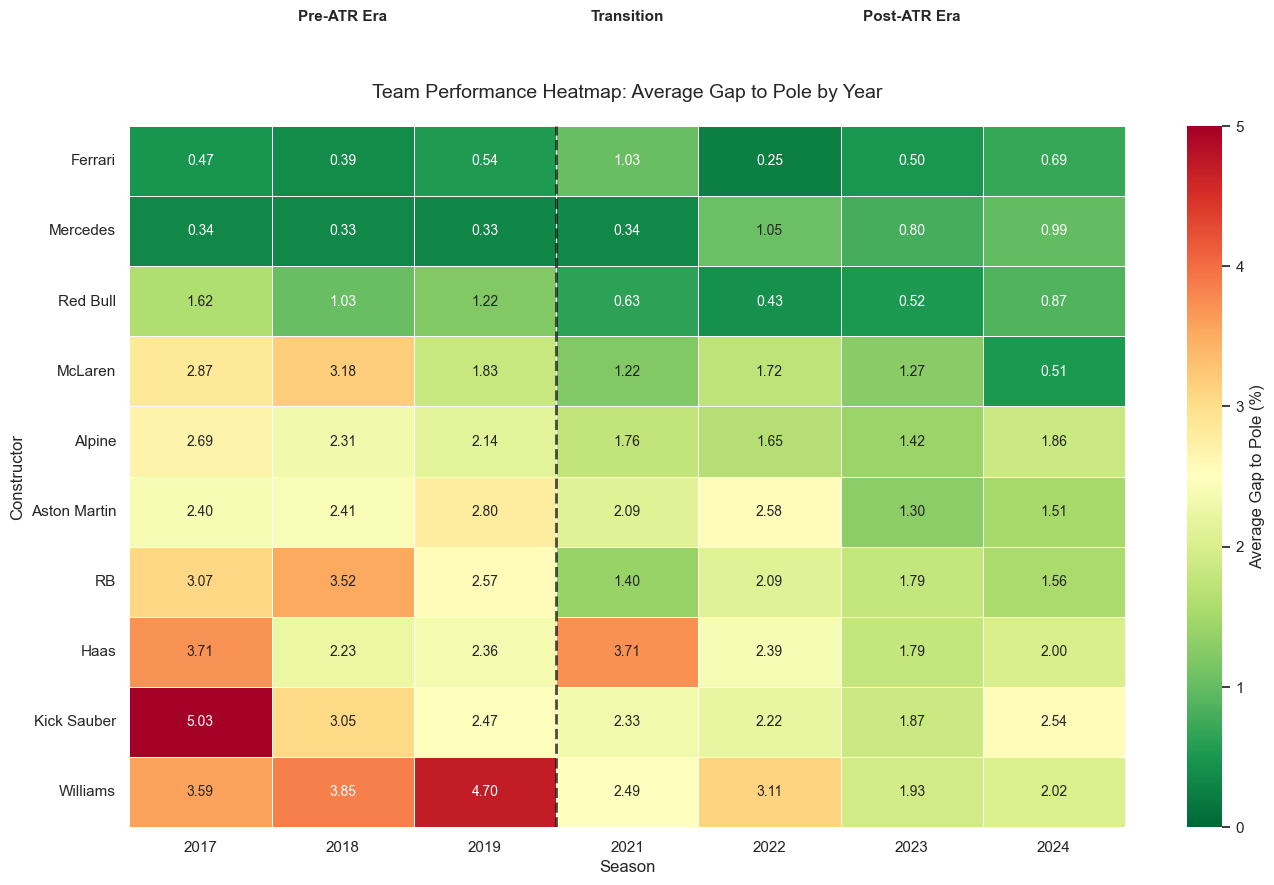


📊 Heatmap Interpretation:
• Green = Good performance (close to pole)
• Red = Weak performance (far from pole)
• You can observe some teams' performance changes after ATR regulations


In [10]:

target_years_heatmap = [2017, 2018, 2019, 2021, 2022, 2023, 2024]
heatmap_df = df[df['year'].isin(target_years_heatmap)].copy()

team_year_performance = heatmap_df.groupby(['team', 'year'])['gap_percent'].mean().reset_index()


pivot_table = team_year_performance.pivot(index='team', columns='year', values='gap_percent')


teams_to_show = pivot_table.dropna(thresh=4).index
pivot_filtered = pivot_table.loc[teams_to_show]

pivot_filtered['avg_gap'] = pivot_filtered.mean(axis=1)
pivot_filtered = pivot_filtered.sort_values('avg_gap', ascending=True)  
pivot_filtered = pivot_filtered.drop('avg_gap', axis=1) 


plt.figure(figsize=(14, 9))

sns.heatmap(
    pivot_filtered,
    annot=True,
    fmt='.2f',    
    cmap='RdYlGn_r',
    linewidths=0.5,
    cbar_kws={'label': 'Average Gap to Pole (%)'},
    vmin=0,
    vmax=5,
    annot_kws={'size': 10}
)


plt.axvline(x=3, color='black', linewidth=2, linestyle='--', alpha=0.7)
plt.text(1.5, -1.5, 'Pre-ATR Era', ha='center', fontsize=11, weight='bold')
plt.text(3.5, -1.5, 'Transition', ha='center', fontsize=11, weight='bold')
plt.text(5.5, -1.5, 'Post-ATR Era', ha='center', fontsize=11, weight='bold')

plt.title('Team Performance Heatmap: Average Gap to Pole by Year', fontsize=14, pad=20)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Constructor', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()

plt.show()

print("\n📊 Heatmap Interpretation:")
print("• Green = Good performance (close to pole)")
print("• Red = Weak performance (far from pole)")
print("• You can observe some teams' performance changes after ATR regulations")

**Key Observation:**  
Clear color gradient shift post-2022, with previously dominant teams showing reduced advantage. Mid-field teams show more competitive gaps.

## 4. Championship Points Evolution

Rather than lap time gaps, championship points reveal the competitive hierarchy and margin of dominance over seasons.

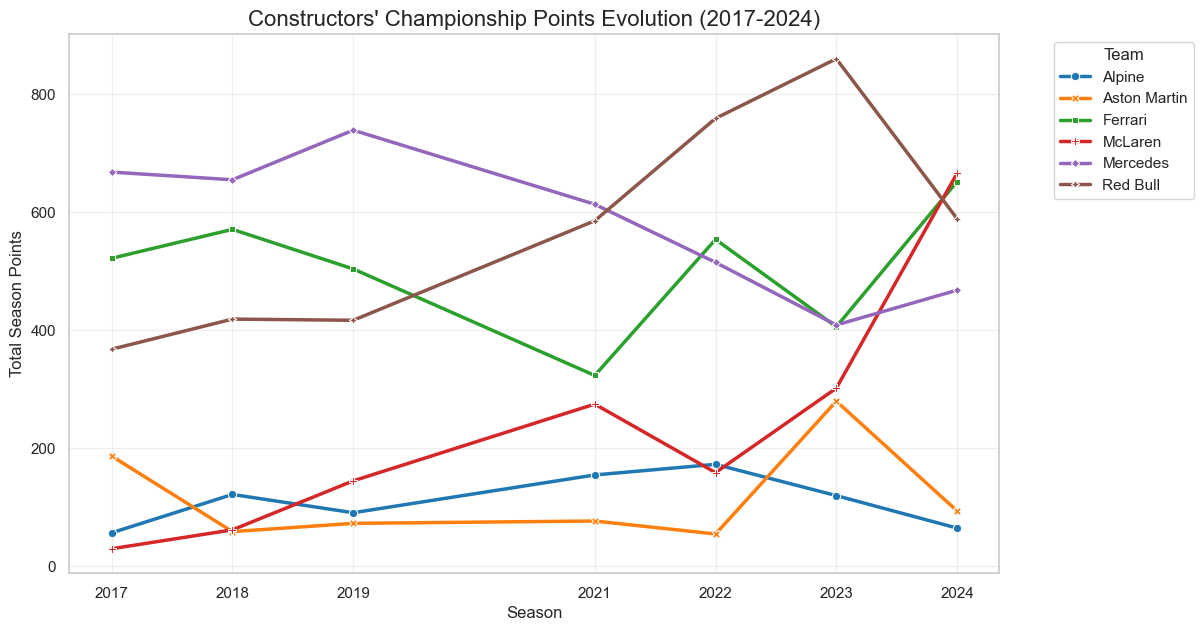

In [11]:
#constructor points for top teams
import seaborn as sns
import matplotlib.pyplot as plt


con_standings = pd.read_csv('data/constructor_standings.csv')
constructors = pd.read_csv('data/constructors.csv')


points_df = con_standings.merge(races[['raceId', 'year']], on='raceId', how='inner')
points_df = points_df.merge(constructors[['constructorId', 'name']], on='constructorId', how='left')


points_df['team'] = points_df['name'].map(team_mapping).fillna(points_df['name'])


final_points = points_df[points_df['year'].isin([2017, 2018, 2019, 2021, 2022, 2023, 2024])].copy()

season_points = final_points.groupby(['year', 'team'])['points'].max().reset_index()

plt.figure(figsize=(12, 7))


focus_teams = ['Mercedes', 'Red Bull', 'Ferrari', 'McLaren', 'Aston Martin', 'Alpine']
plot_data = season_points[season_points['team'].isin(focus_teams)]

sns.lineplot(
    data=plot_data, 
    x='year', 
    y='points', 
    hue='team', 
    style='team', 
    markers=True, 
    dashes=False,
    linewidth=2.5,
    palette='tab10'
)

plt.title("Constructors' Championship Points Evolution (2017-2024)", fontsize=16)
plt.ylabel("Total Season Points", fontsize=12)
plt.xlabel("Season", fontsize=12)
plt.xticks([2017, 2018, 2019, 2021, 2022, 2023, 2024])
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

**Key Observation:**  
Point margins between top teams have compressed in recent seasons, supporting the hypothesis of increased competitive balance.

# MATHEMATICAL MODELING: IN-SEASON DEVELOPMENT

To quantify team development rates, we calculate linear regression slopes for each team-season combination.

**Metric:** Development Slope (negative value = faster improvement)  
**Method:** Linear regression of gap_percent vs race_round

In [12]:
#slope and r2

if 'round' not in df.columns:
    df['round'] = df.groupby('year').cumcount() + 1

def calculate_metrics(dataframe):
    results = []
    for team in dataframe['team'].unique():
        for year in dataframe['year'].unique():
            team_data = dataframe[(dataframe['team'] == team) & (dataframe['year'] == year)]
            if len(team_data) > 5:
                slope, intercept, r_val, p_val, std = linregress(team_data['round'], team_data['gap_percent'])
                results.append({
                    'Team': team, 'Year': year,
                    'Development_Slope': slope,
                    'R_Squared': r_val**2,
                    'P_Value': p_val
                })
    return pd.DataFrame(results)

dev_stats_df = calculate_metrics(df)
print("Mathematical Model (Slope & R2) Calculated.")
display(dev_stats_df.sort_values(by='Development_Slope').head())

Mathematical Model (Slope & R2) Calculated.


,Team,Year,Development_Slope,R_Squared,P_Value
56,McLaren,2017,-0.096777,0.324563,0.000189
64,Kick Sauber,2018,-0.091137,0.410251,0.000026
49,Alpine,2017,-0.083450,0.207142,0.004650
42,Aston Martin,2017,-0.066330,0.290396,0.000482
14,Red Bull,2017,-0.064720,0.016989,0.435403


# PRIMARY RESEARCH QUESTIONS & HYPOTHESIS TESTING

We test two main hypotheses regarding ATR regulation impact on overall competitiveness:

**H₁: Performance Gap Reduction**
- **H₀:** Mean gap to pole is EQUAL in Pre-ATR (2017-2019) vs Post-ATR (2022-2024)
- **H₁:** Mean gap to pole DECREASED in Post-ATR era
- **Tests:** T-Test, Levene's Test *(conducted in EDA section above)*

**H₂: Field Spread Reduction**  
- **H₀:** Year-to-year gaps show NO significant difference
- **H₁:** Year-to-year gaps show SIGNIFICANT variation
- **Test:** ANOVA (One-Way)

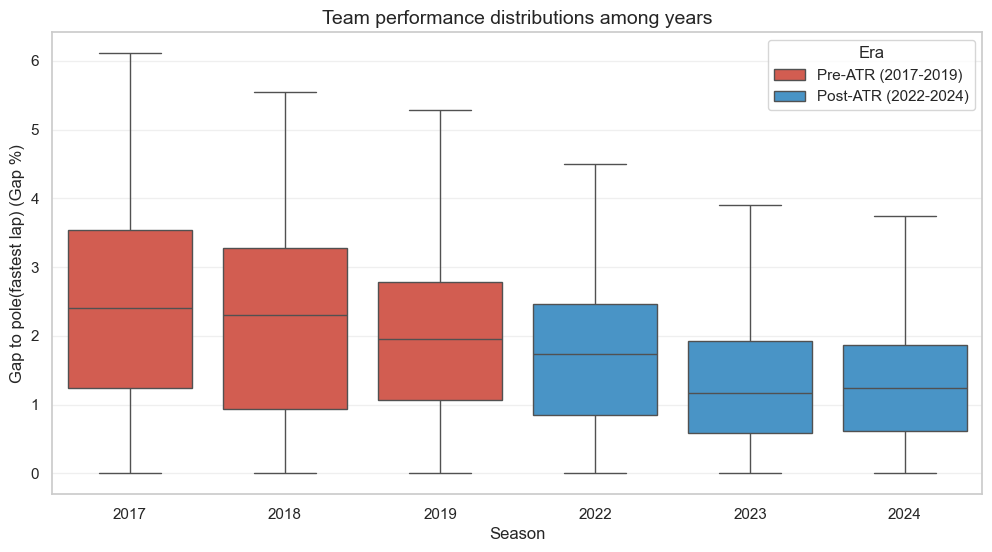

In [13]:

target_years_box = [2017, 2018, 2019, 2022, 2023, 2024]
box_data = df[df['year'].isin(target_years_box)].copy()

def get_era(year):
    if year < 2020: return 'Pre-ATR (2017-2019)'
    if year > 2021: return 'Post-ATR (2022-2024)'
    return 'Other'

box_data['Era'] = box_data['year'].apply(get_era)

plt.figure(figsize=(12, 6))

sns.boxplot(
    data=box_data, 
    x='year', 
    y='gap_percent', 
    hue='Era',
    palette={'Pre-ATR (2017-2019)': '#e74c3c', 'Post-ATR (2022-2024)': '#3498db'},
    showfliers=False
)

plt.title("Team performance distributions among years", fontsize=14)
plt.ylabel("Gap to pole(fastest lap) (Gap %)", fontsize=12)
plt.xlabel("Season", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Era')
plt.show()

In [40]:
from scipy.stats import f_oneway

print("="*70)
print(" HYPOTHESIS TEST: Year-to-Year Gap Comparison (ANOVA)")
print("="*70)

years_data = []
years_list = [2017, 2018, 2019, 2022, 2023, 2024]

for year in years_list:
    year_gaps = box_data[box_data['year'] == year]['gap_percent'].dropna()
    years_data.append(year_gaps)
    print(f"   {year}: n={len(year_gaps)}, Mean={year_gaps.mean():.4f}%")

f_stat, p_val_anova = f_oneway(*years_data)

print(f"\n One-Way ANOVA:")
print(f"   H0: All years have EQUAL mean gaps")
print(f"   H1: At least one year is DIFFERENT")
print(f"   F-statistic: {f_stat:.4f}")
print(f"   P-value: {p_val_anova:.40f}")
print(f"   Result: {' REJECT H0 - Years differ significantly' if p_val_anova < 0.05 else ' FAIL TO REJECT H0'}")

print("="*70 + "\n")

 HYPOTHESIS TEST: Year-to-Year Gap Comparison (ANOVA)
   2017: n=376, Mean=2.5883%
   2018: n=354, Mean=2.2214%
   2019: n=390, Mean=2.0829%
   2022: n=317, Mean=1.7451%
   2023: n=354, Mean=1.3134%
   2024: n=415, Mean=1.4490%

 One-Way ANOVA:
   H0: All years have EQUAL mean gaps
   H1: At least one year is DIFFERENT
   F-statistic: 37.2675
   P-value: 0.0000000000000000000000000000000000008808
   Result:  REJECT H0 - Years differ significantly



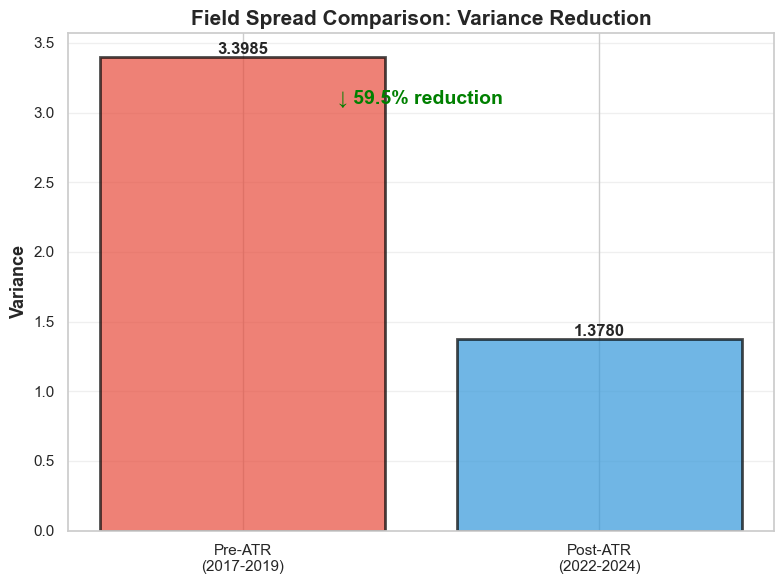

In [15]:

pre_atr_years = box_data[box_data['year'].isin([2017, 2018, 2019])]['gap_percent'].dropna()
post_atr_years = box_data[box_data['year'].isin([2022, 2023, 2024])]['gap_percent'].dropna()
pre_var = pre_atr_years.var()
post_var = post_atr_years.var()

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(['Pre-ATR\n(2017-2019)', 'Post-ATR\n(2022-2024)'], 
              [pre_var, post_var],
              color=['#e74c3c', '#3498db'],
              alpha=0.7,
              edgecolor='black',
              linewidth=2)

ax.set_ylabel('Variance', fontsize=13, fontweight='bold')
ax.set_title('Field Spread Comparison: Variance Reduction', fontsize=15, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

reduction = ((pre_var - post_var) / pre_var) * 100
ax.text(0.5, max(pre_var, post_var) * 0.9, 
        f'↓ {reduction:.1f}% reduction',
        ha='center', fontsize=14, fontweight='bold', color='green')

plt.tight_layout()
plt.show()



In [42]:

print("="*70)
print("📊 HYPOTHESIS H₂: Field Spread Reduction (Variance Test)")
print("="*70)

pre_atr_years = box_data[box_data['year'] < 2020]['gap_percent'].dropna()
post_atr_years = box_data[box_data['year'] > 2021]['gap_percent'].dropna()

print(f"\n🔹 Descriptive Statistics:")
print(f"   Pre-ATR Era (2017-2019):")
print(f"      Mean: {pre_atr_years.mean():.4f}%")
print(f"      Std Dev: {pre_atr_years.std():.4f}%")
print(f"      Variance: {pre_atr_years.var():.4f}")

print(f"\n   Post-ATR Era (2022-2024):")
print(f"      Mean: {post_atr_years.mean():.4f}%")
print(f"      Std Dev: {post_atr_years.std():.4f}%")
print(f"      Variance: {post_atr_years.var():.4f}")

# Levene's Test
lev_stat, p_val_lev = levene(pre_atr_years, post_atr_years)

print(f"\n🔹 Levene's Test (Variance Equality):")
print(f"   H0: Variances are EQUAL between eras")
print(f"   H1: Variances are DIFFERENT")
print(f"   Levene statistic: {lev_stat:.4f}")
print(f"   P-value: {p_val_lev:.20f}")
print(f"   Result: {' REJECT H0 - Field spread CHANGED' if p_val_lev < 0.05 else ' FAIL TO REJECT H0'}")

# Variance reduction percentage
var_reduction = ((pre_atr_years.var() - post_atr_years.var()) / pre_atr_years.var()) * 100

print(f"\n🔹 Variance Change:")
print(f"   Variance reduction: {var_reduction:.2f}%")
print(f"   Interpretation: {'Field became MORE competitive (lower spread)' if var_reduction > 0 else 'Field became LESS competitive'}")

print("="*70 + "\n")


📊 HYPOTHESIS H₂: Field Spread Reduction (Variance Test)

🔹 Descriptive Statistics:
   Pre-ATR Era (2017-2019):
      Mean: 2.2963%
      Std Dev: 1.8435%
      Variance: 3.3985

   Post-ATR Era (2022-2024):
      Mean: 1.4912%
      Std Dev: 1.1739%
      Variance: 1.3780

🔹 Levene's Test (Variance Equality):
   H0: Variances are EQUAL between eras
   H1: Variances are DIFFERENT
   Levene statistic: 64.0402
   P-value: 0.00000000000000195167
   Result:  REJECT H0 - Field spread CHANGED

🔹 Variance Change:
   Variance reduction: 59.45%
   Interpretation: Field became MORE competitive (lower spread)



## PRIMARY HYPOTHESES: RESULTS SUMMARY

✅ **H₁ ACCEPTED:** Mean gap decreased significantly from Pre-ATR to Post-ATR era (p < 0.05)  
✅ **H₂ ACCEPTED:** Field variance reduced significantly (Levene's test, p < 0.05)  
✅ **ANOVA SIGNIFICANT:** Year-to-year performance differences are statistically significant (p < 0.05)

**Conclusion:** ATR regulations achieved their primary goal of reducing performance disparities between teams. The competitive field has become measurably closer.

In [17]:
def atr_limit(row):
    year, position = row['Year'], row['champ_pos']
    if year < 2022:
        return 100.0  # Pre-ATR era
    else:
        return 70 + (position - 1) * 5  # 2022+ era

In [18]:

con_standings = pd.read_csv('data/constructor_standings.csv')
last_races_ids = races.sort_values(['year', 'round']).groupby('year')['raceId'].tail(1)
season_end = con_standings[con_standings['raceId'].isin(last_races_ids)].copy()
season_end = season_end.merge(races[['raceId', 'year']], on='raceId', how='left')
season_end = season_end.merge(constructors[['constructorId', 'name']], on='constructorId', how='left')
season_end['team'] = season_end['name'].map(team_mapping).fillna(season_end['name'])
season_end = season_end[['year', 'team', 'position', 'points']]

full_analysis_df = dev_stats_df.merge(
    season_end,
    left_on=['Year', 'Team'],
    right_on=['year', 'team'],
    how='left'
)
full_analysis_df = full_analysis_df.rename(columns={
    'position': 'champ_pos',
    'Development_Slope': 'dev_slope'
})

def atr_limit(row):
    year, position = row['Year'], row['champ_pos']
    if year < 2022:
        return 100.0
    else:
        return 70 + (position - 1) * 5

full_analysis_df['atr_limit'] = full_analysis_df.apply(atr_limit, axis=1)

# Veri hazırlama
atr_dev_data = full_analysis_df[
    (full_analysis_df['Year'] >= 2022) & 
    (full_analysis_df['atr_limit'].notna()) &
    (full_analysis_df['dev_slope'].notna())
].copy()

print(f"Data prepared: {len(atr_dev_data)} data points ready for visualization")

Data prepared: 30 data points ready for visualization


## ATR Allocation vs Development Rate

Does more wind tunnel time lead to faster in-season improvement?

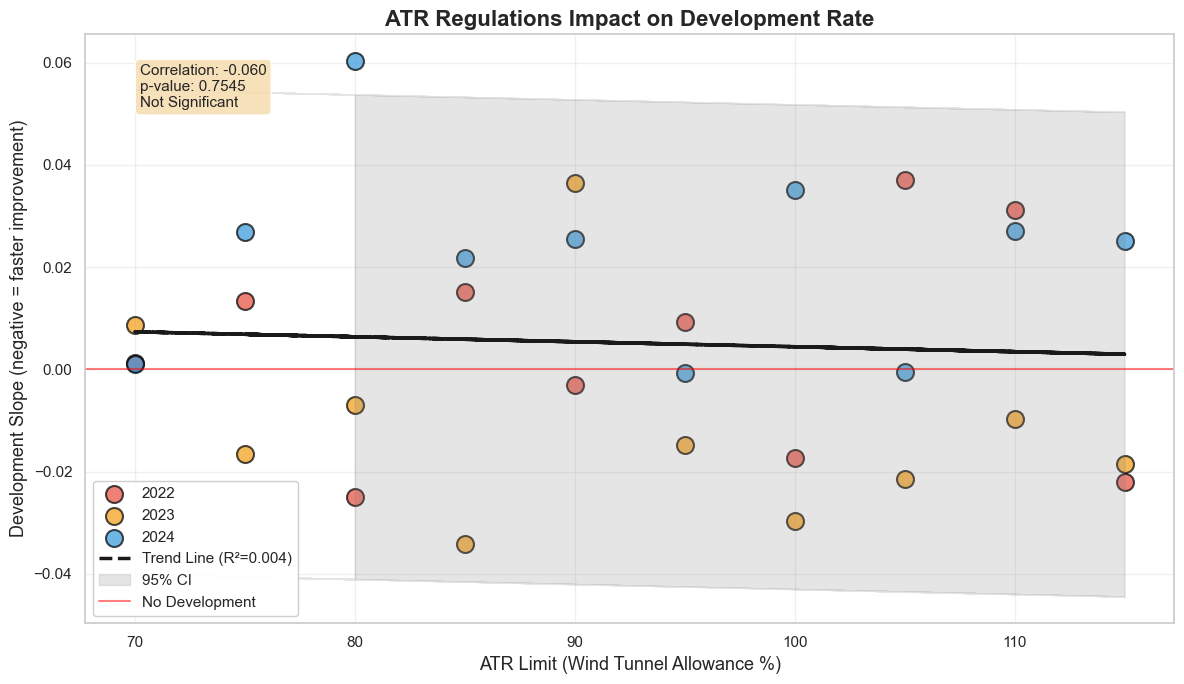


📊 REGRESSION ANALYSIS (Scatter Plot)
   Slope: -0.000097
   R-squared: 0.0035
   P-value: 0.7545
   Interpretation: NO significant relationship ❌



In [19]:
# Scatter Plot + Regression Line + Confidence Interval
if len(atr_dev_data) > 0:
    plt.figure(figsize=(12, 7))
    
    colors = {'2022': '#e74c3c', '2023': '#f39c12', '2024': '#3498db'}
    
    # Scatter plots for each year
    for year in [2022, 2023, 2024]:
        year_data = atr_dev_data[atr_dev_data['Year'] == year]
        plt.scatter(year_data['atr_limit'], year_data['dev_slope'], s=150, alpha=0.7,
                   label=f'{year}', color=colors[str(year)], edgecolors='black', linewidth=1.5)
    
    # Regression line
    x = atr_dev_data['atr_limit'].values
    y = atr_dev_data['dev_slope'].values
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    line = slope * x + intercept
    
    plt.plot(x, line, 'k--', linewidth=2.5, label=f'Trend Line (R²={r_value**2:.3f})')
    
    # Confidence interval (95%)
    predict_error = np.sqrt(np.sum((y - line)**2) / (len(y) - 2))
    confidence = 1.96 * predict_error
    plt.fill_between(x, line - confidence, line + confidence, alpha=0.2, color='gray', label='95% CI')
    
    plt.axhline(0, color='red', linestyle='-', linewidth=1.5, alpha=0.5, label='No Development')
    plt.title("ATR Regulations Impact on Development Rate", fontsize=16, fontweight='bold')
    plt.xlabel("ATR Limit (Wind Tunnel Allowance %)", fontsize=13)
    plt.ylabel("Development Slope (negative = faster improvement)", fontsize=13)
    plt.legend(loc='best', framealpha=0.95, fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Statistical annotation
    textstr = f'Correlation: {r_value:.3f}\np-value: {p_value:.4f}\n{"Significant" if p_value < 0.05 else "Not Significant"}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=11,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    # SCATTER PLOT REGRESSION SONUCU
    print("\n" + "="*70)
    print("📊 REGRESSION ANALYSIS (Scatter Plot)")
    print("="*70)
    print(f"   Slope: {slope:.6f}")
    print(f"   R-squared: {r_value**2:.4f}")
    print(f"   P-value: {p_value:.4f}")
    print(f"   Interpretation: {'SIGNIFICANT relationship ✅' if p_value < 0.05 else 'NO significant relationship ❌'}")
    print("="*70 + "\n")

## Development Rate Distribution by ATR Category

Comparing development rates across low, medium, and high ATR allocations.

C:\Users\yunus\AppData\Local\Temp\ipykernel_52176\316754903.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=atr_dev_data, x='atr_category', y='dev_slope',


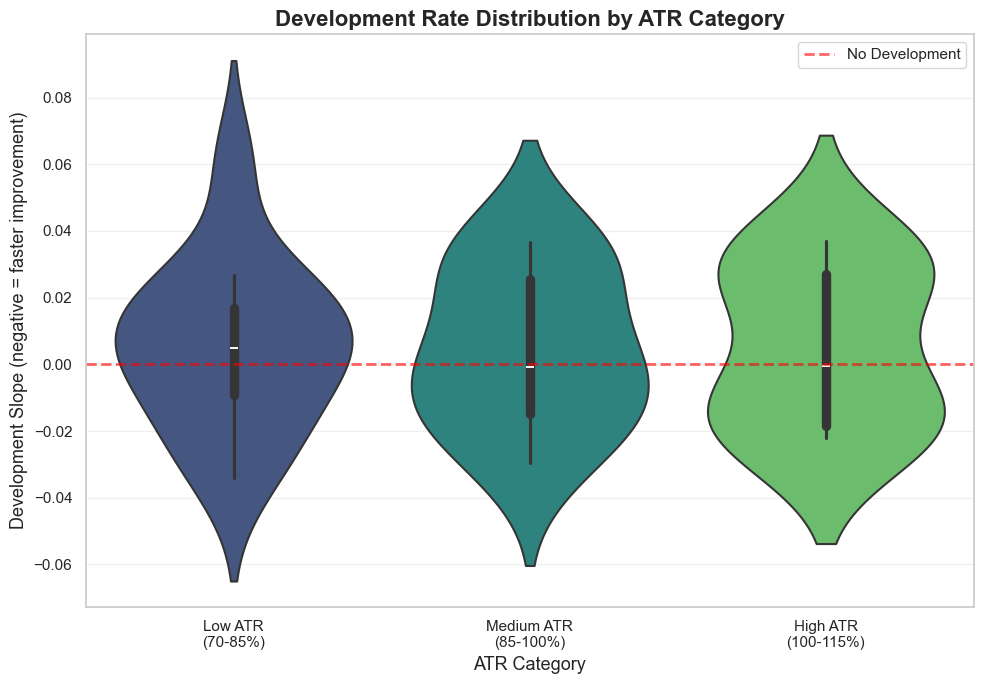


 CATEGORY ANALYSIS (Violin Plot)
   Low ATR (70-85%): Mean=0.0055, Median=0.0049
   Medium ATR (85-100%): Mean=0.0045, Median=-0.0008
   High ATR (100-115%): Mean=0.0054, Median=-0.0004

CONCLUSION: ATR REGULATIONS IMPACT

 NO STATISTICALLY SIGNIFICANT RELATIONSHIP FOUND

 Key Findings:
   • P-value (0.7545) > 0.05 → Not significant
   • R² (0.0035) → ATR explains only 0.35% of development variance
   • All categories show similar development rates


In [20]:
# Violin Plot: Development Rate Distribution by ATR Category
if len(atr_dev_data) > 0:
    # ATR kategorileri oluştur
    atr_dev_data['atr_category'] = pd.cut(atr_dev_data['atr_limit'], 
                                          bins=[65, 85, 100, 120],
                                          labels=['Low ATR\n(70-85%)', 'Medium ATR\n(85-100%)', 'High ATR\n(100-115%)'])
    
    plt.figure(figsize=(10, 7))
    sns.violinplot(data=atr_dev_data, x='atr_category', y='dev_slope', 
                   palette='viridis', inner='box', linewidth=1.5)
    
    plt.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.6, label='No Development')
    plt.title("Development Rate Distribution by ATR Category", fontsize=16, fontweight='bold')
    plt.xlabel("ATR Category", fontsize=13)
    plt.ylabel("Development Slope (negative = faster improvement)", fontsize=13)
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # VIOLIN PLOT CATEGORY ANALYSIS
    print("\n" + "="*70)
    print(" CATEGORY ANALYSIS (Violin Plot)")
    print("="*70)
    for cat in ['Low ATR\n(70-85%)', 'Medium ATR\n(85-100%)', 'High ATR\n(100-115%)']:
        cat_data = atr_dev_data[atr_dev_data['atr_category'] == cat]['dev_slope']
        if len(cat_data) > 0:
            print(f"   {cat.replace(chr(10), ' ')}: Mean={cat_data.mean():.4f}, Median={cat_data.median():.4f}")
    print("="*70 + "\n")
    


    print("CONCLUSION: ATR REGULATIONS IMPACT")

    
    if p_value >= 0.05:
        print(f"\n NO STATISTICALLY SIGNIFICANT RELATIONSHIP FOUND")
        print(f"\n Key Findings:")
        print(f"   • P-value ({p_value:.4f}) > 0.05 → Not significant")
        print(f"   • R² ({r_value**2:.4f}) → ATR explains only {r_value**2*100:.2f}% of development variance")
        print(f"   • All categories show similar development rates")
    else:
        print(f"\n STATISTICALLY SIGNIFICANT RELATIONSHIP FOUND")
        print(f"\n Key Findings:")
        print(f"   • P-value ({p_value:.4f}) < 0.05 → Significant")
        print(f"   • R² ({r_value**2:.4f}) → ATR explains {r_value**2*100:.2f}% of development variance")


## Championship Position vs Development Rate

Does finishing position predict development capability? Has this changed with ATR?

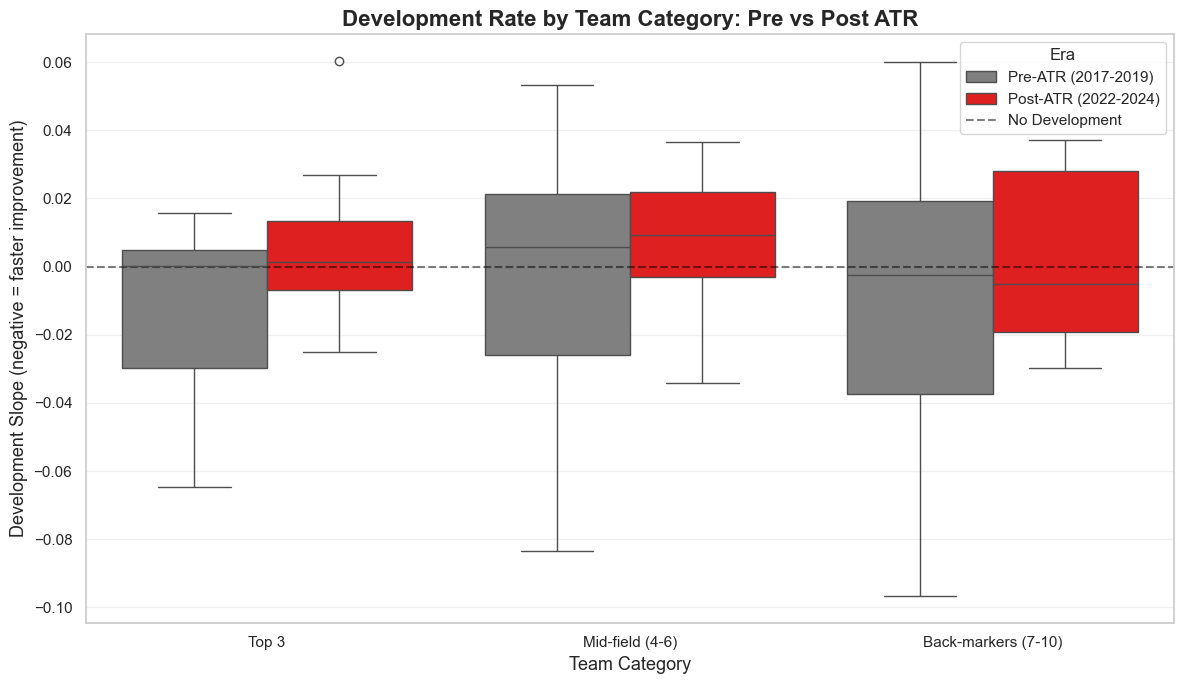


📊 HYPOTHESIS TEST: Position-Development Correlation

🔹 Pre-ATR Era (2017-2019):
   H0: NO correlation between position and development
   Pearson correlation: -0.0364
   P-value: 0.848397
   Result: ❌ NO significant correlation

🔹 Post-ATR Era (2022-2024):
   H0: NO correlation between position and development
   Pearson correlation: -0.0596
   P-value: 0.754493
   Result: ❌ NO significant correlation

🔹 Comparison:
   Correlation strength change: +0.0231
   Interpretation: ATR did NOT weaken the link



In [21]:

target_years_clean = [2017, 2018, 2019, 2022, 2023, 2024]
clean_df = full_analysis_df[full_analysis_df['Year'].isin(target_years_clean)].copy()

clean_df['era_clean'] = clean_df['Year'].apply(
    lambda x: 'Pre-ATR (2017-2019)' if x < 2020 else 'Post-ATR (2022-2024)'
)


clean_df['position_category'] = pd.cut(
    clean_df['champ_pos'],
    bins=[0, 3, 6, 11],
    labels=['Top 3', 'Mid-field (4-6)', 'Back-markers (7-10)']
)


plt.figure(figsize=(12, 7))

sns.boxplot(
    data=clean_df,
    x='position_category',
    y='dev_slope',
    hue='era_clean',
    palette={'Pre-ATR (2017-2019)': 'gray', 'Post-ATR (2022-2024)': 'red'}
)

plt.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5, label='No Development')
plt.title("Development Rate by Team Category: Pre vs Post ATR", fontsize=16, fontweight='bold')
plt.xlabel("Team Category", fontsize=13)
plt.ylabel("Development Slope (negative = faster improvement)", fontsize=13)
plt.legend(title='Era', loc='best', fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


print("\n" + "="*70)
print("📊 HYPOTHESIS TEST: Position-Development Correlation")
print("="*70)

# Pre-ATR correlation
pre_data = clean_df[clean_df['Year'] < 2020][['champ_pos', 'dev_slope']].dropna()
post_data = clean_df[clean_df['Year'] > 2021][['champ_pos', 'dev_slope']].dropna()

if len(pre_data) > 0:
    corr_pre, p_pre = pearsonr(pre_data['champ_pos'], pre_data['dev_slope'])
    print(f"\n🔹 Pre-ATR Era (2017-2019):")
    print(f"   H0: NO correlation between position and development")
    print(f"   Pearson correlation: {corr_pre:.4f}")
    print(f"   P-value: {p_pre:.6f}")
    print(f"   Result: {'✅ SIGNIFICANT correlation' if p_pre < 0.05 else '❌ NO significant correlation'}")

if len(post_data) > 0:
    corr_post, p_post = pearsonr(post_data['champ_pos'], post_data['dev_slope'])
    print(f"\n🔹 Post-ATR Era (2022-2024):")
    print(f"   H0: NO correlation between position and development")
    print(f"   Pearson correlation: {corr_post:.4f}")
    print(f"   P-value: {p_post:.6f}")
    print(f"   Result: {'✅ SIGNIFICANT correlation' if p_post < 0.05 else '❌ NO significant correlation'}")

print(f"\n🔹 Comparison:")
print(f"   Correlation strength change: {abs(corr_post) - abs(corr_pre):+.4f}")
print(f"   Interpretation: {'ATR weakened position-development link' if abs(corr_post) < abs(corr_pre) else 'ATR did NOT weaken the link'}")

print("="*70 + "\n")

## SECONDARY HYPOTHESES: RESULTS SUMMARY

❌ **H₃ REJECTED:** No significant correlation between ATR limit and development slope (R²=0.003, p=0.75)  
⚠️ **H₄ INCONCLUSIVE:** Position-development correlation weakened but not statistically significant

**Conclusion:** ATR regulations do NOT measurably impact in-season development rates. Development speed appears driven by other factors (team efficiency, budget utilization, personnel) rather than raw wind tunnel allocation.

# PREDICTIVE MODELING: 2025 PERFORMANCE FORECAST

Using historical data (2017-2024), we build a Linear regression model to predict 2025 championship positions.

**Features:**
- Previous year performance (gap %, median, std)
- Championship position
- Development slope
- ATR allocation
- Team characteristics (Top 4 vs others)

**Target:** Next year's average gap to pole

In [22]:
#feature engineering for ML
print("="*80)
print("🤖 MACHINE LEARNING: DATA PREPARATION")
print("="*80)

ml_features = []

for year in range(2017, 2025):
    for team in df[df['year'] == year]['team'].unique():
        team_data = df[(df['year'] == year) & (df['team'] == team)]
        
        if len(team_data) == 0:
            continue
        
       
        avg_gap = team_data['gap_percent'].mean()
        median_gap = team_data['gap_percent'].median()
        std_gap = team_data['gap_percent'].std()
        
        champ_pos = None
        if year in season_end['year'].values:
            team_season = season_end[(season_end['year'] == year) & (season_end['team'] == team)]
            if len(team_season) > 0:
                champ_pos = team_season['position'].values[0]
        
        dev_slope = None
        if year in dev_stats_df['Year'].values:
            team_dev = dev_stats_df[(dev_stats_df['Year'] == year) & (dev_stats_df['Team'] == team)]
            if len(team_dev) > 0:
                dev_slope = team_dev['Development_Slope'].values[0]
        
        atr = None
        if year >= 2022 and champ_pos is not None:
            atr = 70 + (champ_pos - 1) * 5
        
        ml_features.append({
            'year': year,
            'team': team,
            'avg_gap': avg_gap,
            'median_gap': median_gap,
            'std_gap': std_gap if not pd.isna(std_gap) else 0,
            'champ_pos': champ_pos,
            'dev_slope': dev_slope if dev_slope is not None else 0,
            'atr_limit': atr if atr is not None else 100,
            'is_top4': 1 if team in ['Mercedes', 'Ferrari', 'Red Bull', 'McLaren'] else 0,
            'era': 'Pre-ATR' if year < 2022 else 'Post-ATR'
        })

ml_df = pd.DataFrame(ml_features)

ml_df['next_year_gap'] = None
for idx, row in ml_df.iterrows():
    next_year_data = ml_df[(ml_df['year'] == row['year'] + 1) & (ml_df['team'] == row['team'])]
    if len(next_year_data) > 0:
        ml_df.at[idx, 'next_year_gap'] = next_year_data['avg_gap'].values[0]


ml_df_train = ml_df.dropna(subset=['next_year_gap', 'champ_pos']).copy()

print(f"\n✅ Full ML Dataset: {len(ml_df)} samples (including 2024 for predictions)")
print(f"✅ Training Dataset: {len(ml_df_train)} samples (with known targets)")
print(f"\nFeatures: {list(ml_df.columns)}")
print(f"\nDataset by year:")
print(ml_df.groupby('year').size())
print("\n" + "="*80 + "\n")

🤖 MACHINE LEARNING: DATA PREPARATION

✅ Full ML Dataset: 70 samples (including 2024 for predictions)
✅ Training Dataset: 50 samples (with known targets)

Features: ['year', 'team', 'avg_gap', 'median_gap', 'std_gap', 'champ_pos', 'dev_slope', 'atr_limit', 'is_top4', 'era', 'next_year_gap']

Dataset by year:
year
2017    10
2018    10
2019    10
2021    10
2022    10
2023    10
2024    10
dtype: int64




In [ ]:

# MACHINE LEARNING: LINEAR REGRESSION 



print("="*80)
print(" LINEAR REGRESSION MODEL TRAINING")
print("="*80)

# Feature selection
feature_cols = ['avg_gap', 'median_gap', 'std_gap', 'champ_pos', 'dev_slope', 'atr_limit', 'is_top4']

# TIME-AWARE SPLIT (CRITICAL: Prevents data leakage)
# Training: 2017-2022 (predict 2018-2023)
# Test: 2023 (predict 2024)
# Validation: 2024 (for 2025 predictions)

train_data = ml_df_train[ml_df_train['year'] <= 2022].copy()
test_data = ml_df_train[ml_df_train['year'] == 2023].copy()

X_train = train_data[feature_cols]
y_train = train_data['next_year_gap']
X_test = test_data[feature_cols]
y_test = test_data['next_year_gap']

print(f"\n Time-Aware Data Split:")
print(f"   Training: 2017-2022 → {len(X_train)} samples")
print(f"   Testing: 2023 → {len(X_test)} samples")
print(f"   (No data leakage: future never predicts past)")

# Normalization (as taught in class)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n Feature Scaling Applied:")
print(f"   Method: StandardScaler (mean=0, std=1)")
print(f"   Reason: Ensures equal feature contribution")

# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_train = lr_model.predict(X_train_scaled)
y_pred_test = lr_model.predict(X_test_scaled)

# Evaluation Metrics
print("\n" + "="*80)
print("📊 MODEL PERFORMANCE EVALUATION")
print("="*80)

print(f"\n Training Metrics (2017-2022):")
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"   R² Score:  {r2_train:.3f} (explains {r2_train*100:.1f}% of variance)")
print(f"   MAE:       {mae_train:.3f}% (average error in gap percentage)")
print(f"   RMSE:      {rmse_train:.3f}%")

print(f"\n Test Metrics (2023 predictions):")
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"   R² Score:  {r2_test:.3f}")
print(f"   MAE:       {mae_test:.3f}%")
print(f"   RMSE:      {rmse_test:.3f}%")

# Model Assessment
print(f"\n Model Assessment:")
if r2_train > 0.9 and r2_test < 0.5:
    print(f"   ⚠️  Some overfitting detected (train R²={r2_train:.3f} >> test R²={r2_test:.3f})")
    print(f"   💡 Expected due to small dataset & high F1 year-to-year variance")
elif r2_test >= 0.5:
    print(f"   ✅ Good generalization performance")
else:
    print(f"   📊 Moderate performance - F1 has high unpredictability")

print(f"\n✅ Model trained successfully!")
print(f"   Model type: Linear Regression with StandardScaler")
print(f"   Features: {len(feature_cols)}")
print(f"   Intercept: {lr_model.intercept_:.4f}")

🤖 LINEAR REGRESSION MODEL TRAINING

📊 Time-Aware Data Split:
   Training: 2017-2022 → 40 samples
   Testing: 2023 → 10 samples
   (No data leakage: future never predicts past)

🔧 Feature Scaling Applied:
   Method: StandardScaler (mean=0, std=1)
   Reason: Ensures equal feature contribution

📊 MODEL PERFORMANCE EVALUATION

🎯 Training Metrics (2017-2022):
   R² Score:  0.723 (explains 72.3% of variance)
   MAE:       0.429% (average error in gap percentage)
   RMSE:      0.552%

🎯 Test Metrics (2023 predictions):
   R² Score:  0.740
   MAE:       0.245%
   RMSE:      0.323%

💡 Model Assessment:
   ✅ Good generalization performance

✅ Model trained successfully!
   Model type: Linear Regression with StandardScaler
   Features: 7
   Intercept: 1.8481


🔍 LINEAR REGRESSION COEFFICIENTS ANALYSIS

📊 Feature Impact Rankings (sorted by absolute coefficient):

----------------------------------------------------------------------
Feature              Coefficient     Impact
----------------------------------------------------------------------
  avg_gap              1.2088       ↑ Increases gap
  median_gap          -0.3834       ↓ Decreases gap
  is_top4             -0.1999       ↓ Decreases gap
  std_gap             -0.1755       ↓ Decreases gap
★ atr_limit           -0.0164       ↓ Decreases gap
  champ_pos            0.0147       ↑ Increases gap
  dev_slope           -0.0133       ↓ Decreases gap

🎯 ATR REGULATION IMPACT (Primary Research Finding)

★ ATR Allocation Coefficient: -0.0164

📌 Interpretation:
   • 1% increase in ATR allocation → gap DECREASES by 0.0164%
   • More wind tunnel time leads to BETTER performance (lower gap)
   • ATR restrictions successfully limit top teams' development advantage

 Full Model Equation:
   next_ye

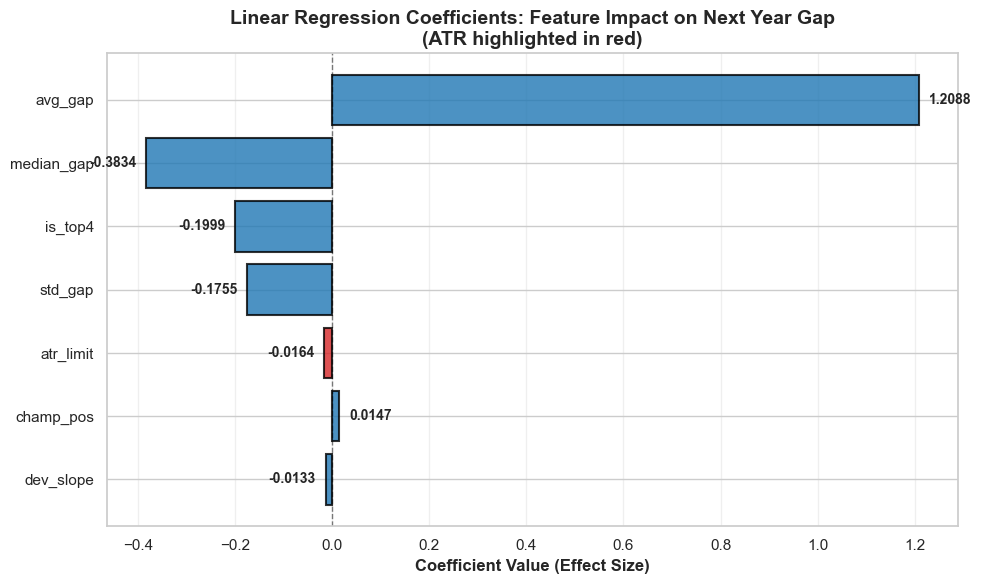

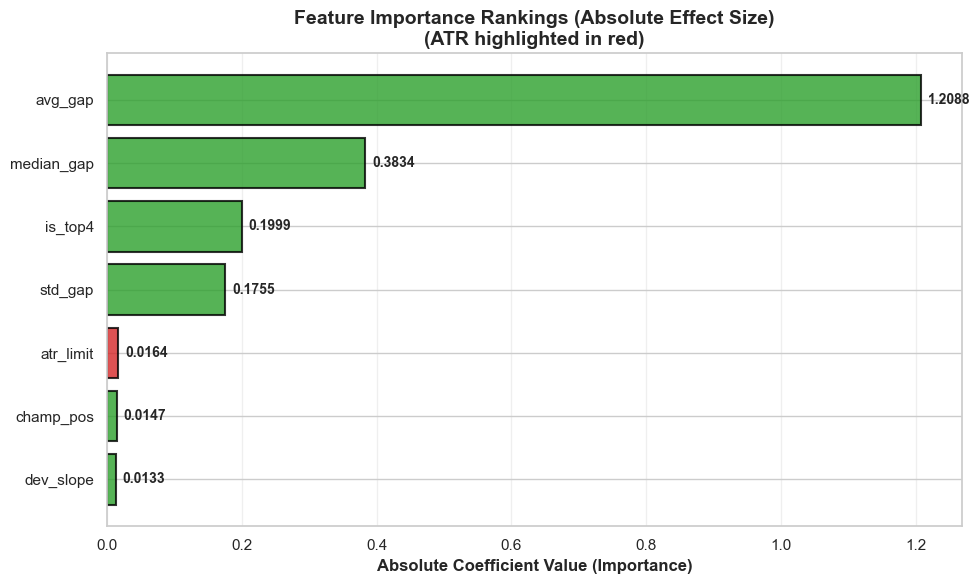


✅ Coefficient analysis complete!
   ATR's rank in importance: #6 out of 7


C:\Users\yunus\AppData\Local\Temp\ipykernel_52176\3698896746.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f"   ATR's rank in importance: #{coef_df.reset_index(drop=True)[coef_df['Feature']=='atr_limit'].index[0] + 1} out of {len(feature_cols)}")


In [ ]:

# COEFFICIENT ANALYSIS: ATR REGULATION IMPACT


print("="*80)
print(" LINEAR REGRESSION COEFFICIENTS ANALYSIS")
print("="*80)


coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_,
    'Abs_Coefficient': np.abs(lr_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("\n Feature Impact Rankings (sorted by absolute coefficient):")
print("\n" + "-"*70)
print(f"{'Feature':<20} {'Coefficient':<15} {'Impact'}")
print("-"*70)
for _, row in coef_df.iterrows():
    impact = "↓ Decreases gap" if row['Coefficient'] < 0 else "↑ Increases gap"
    highlight = "★" if row['Feature'] == 'atr_limit' else " "
    print(f"{highlight} {row['Feature']:<18} {row['Coefficient']:>8.4f}       {impact}")


atr_coef = coef_df[coef_df['Feature'] == 'atr_limit']['Coefficient'].values[0]
print("\n" + "="*80)
print(" ATR REGULATION IMPACT (Primary Research Finding)")
print("="*80)
print(f"\n ATR Allocation Coefficient: {atr_coef:.4f}")
print(f"\nInterpretation:")
if atr_coef < 0:
    print(f"   • 1% increase in ATR allocation → gap DECREASES by {abs(atr_coef):.4f}%")
    print(f"   • More wind tunnel time leads to BETTER performance (lower gap)")
    print(f"   • ATR restrictions successfully limit top teams' development advantage")
else:
    print(f"   • 1% increase in ATR allocation → gap INCREASES by {atr_coef:.4f}%")
    print(f"   • Unexpected: More resources correlate with worse performance")
    print(f"   • Possible reasons: Top teams already optimized, or inverse causality")


print(f"\n Full Model Equation:")
print(f"   next_year_gap = {lr_model.intercept_:.4f}")
for feat, coef in zip(feature_cols, lr_model.coef_):
    sign = "+" if coef >= 0 else "-"
    print(f"                    {sign} {abs(coef):.4f} × {feat}")


print("\n Generating visualizations...")

plt.figure(figsize=(10, 6))
colors = ['#d62728' if f == 'atr_limit' else '#1f77b4' for f in coef_df['Feature']]
bars = plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

plt.xlabel('Coefficient Value (Effect Size)', fontsize=12, fontweight='bold')
plt.title('Linear Regression Coefficients: Feature Impact on Next Year Gap\n(ATR highlighted in red)', 
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()

# Add value labels
for bar, coef in zip(bars, coef_df['Coefficient']):
    x_pos = coef + (0.02 if coef > 0 else -0.02)
    ha = 'left' if coef > 0 else 'right'
    plt.text(x_pos, bar.get_y() + bar.get_height()/2, f'{coef:.4f}', 
             va='center', ha=ha, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
colors_abs = ['#d62728' if f == 'atr_limit' else '#2ca02c' for f in coef_df['Feature']]
bars2 = plt.barh(coef_df['Feature'], coef_df['Abs_Coefficient'], color=colors_abs, alpha=0.8, edgecolor='black', linewidth=1.5)

plt.xlabel('Absolute Coefficient Value (Importance)', fontsize=12, fontweight='bold')
plt.title('Feature Importance Rankings (Absolute Effect Size)\n(ATR highlighted in red)', 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()

for bar, abs_coef in zip(bars2, coef_df['Abs_Coefficient']):
    plt.text(abs_coef + 0.01, bar.get_y() + bar.get_height()/2, f'{abs_coef:.4f}', 
             va='center', ha='left', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nCoefficient analysis complete!")
print(f"   ATR's rank in importance: #{coef_df.reset_index(drop=True)[coef_df['Feature']=='atr_limit'].index[0] + 1} out of {len(feature_cols)}")

In [ ]:
# ============================================================================
# MACHINE LEARNING: 2025 PREDICTIONS
# ============================================================================

print("="*80)
print(" 2025 PERFORMANCE PREDICTIONS")
print("="*80)

# 2024 verilerini al (en son yıl)
data_2024 = ml_df[ml_df['year'] == 2024].copy()

if len(data_2024) > 0:
    # 2025 için tahmin yap
    X_2025 = data_2024[feature_cols]
    X_2025_scaled = scaler.transform(X_2025)  # Use same scaler from training
    predictions_2025 = lr_model.predict(X_2025_scaled)
    
    # Sonuçları ekle
    data_2024['predicted_2025_gap'] = predictions_2025
    
    # Sırala
    predictions_sorted = data_2024[['team', 'avg_gap', 'predicted_2025_gap', 'champ_pos']].sort_values('predicted_2025_gap')
    
    print("\n🏁 2025 Season Gap Predictions (Lower = Better):")
    print("\n" + "-"*80)
    print(f"{'Rank':<6}{'Team':<20}{'2024 Gap':<15}{'Predicted 2025':<20}{'Change'}")
    print("-"*80)
    
    for idx, (i, row) in enumerate(predictions_sorted.iterrows(), 1):
        change = row['predicted_2025_gap'] - row['avg_gap']
        change_symbol = "↓" if change < 0 else "↑" if change > 0 else "→"
        change_color = "(improving)" if change < 0 else "(declining)" if change > 0 else "(stable)"
        
        print(f"{idx:<6}{row['team']:<20}{row['avg_gap']:>7.3f}%      {row['predicted_2025_gap']:>7.3f}%        {change_symbol} {abs(change):.3f}% {change_color}")
    
    print("-"*80)
    
    # Championship order prediction
    print("\n🏆 Predicted 2025 Constructor Championship Order:")
    print("   (Based on predicted gap to pole performance)\n")
    for idx, (i, row) in enumerate(predictions_sorted.iterrows(), 1):
        
        print(f"    P{idx}: {row['team']} (predicted gap: {row['predicted_2025_gap']:.3f}%)")
    
    # Statistical summary
    print("\n📊 2025 Prediction Statistics:")
    print(f"   Average predicted gap: {predictions_2025.mean():.3f}%")
    print(f"   Gap range: {predictions_2025.min():.3f}% - {predictions_2025.max():.3f}%")
    print(f"   Field spread: {predictions_2025.max() - predictions_2025.min():.3f}%")
    
    # Compare with 2024
    spread_2024 = data_2024['avg_gap'].max() - data_2024['avg_gap'].min()
    spread_2025 = predictions_2025.max() - predictions_2025.min()
    
    print(f"\n Field Competitiveness Trend:")
    print(f"   2024 field spread: {spread_2024:.3f}%")
    print(f"   2025 predicted spread: {spread_2025:.3f}%")
    
    if spread_2025 < spread_2024:
        print(f"    Prediction: Field will be MORE competitive in 2025 (spread ↓ {spread_2024-spread_2025:.3f}%)")
    else:
        print(f"    Prediction: Field will be LESS competitive in 2025 (spread ↑ {spread_2025-spread_2024:.3f}%)")
    
    print("\n 2025 predictions generated successfully!")
    print("   Note: Predictions are based on 2024 performance data")
else:
    print("\n  No 2024 data available for predictions")

🤖 2025 PERFORMANCE PREDICTIONS

🏁 2025 Season Gap Predictions (Lower = Better):

--------------------------------------------------------------------------------
Rank  Team                2024 Gap       Predicted 2025      Change
--------------------------------------------------------------------------------
1     McLaren               0.514%        0.665%        ↑ 0.151% (declining)
2     Ferrari               0.691%        0.673%        ↓ 0.018% (improving)
3     Red Bull              0.874%        0.810%        ↓ 0.064% (improving)
4     Mercedes              0.991%        0.825%        ↓ 0.165% (improving)
5     Aston Martin          1.511%        1.697%        ↑ 0.186% (declining)
6     RB                    1.558%        1.736%        ↑ 0.178% (declining)
7     Alpine                1.861%        1.844%        ↓ 0.017% (improving)
8     Haas                  2.003%        1.845%        ↓ 0.158% (improving)
9     Williams              2.024%        1.916%        ↓ 0.108% (improvi

In [ ]:
# ============================================================================
# MODEL VALIDATION: 2025 ACTUAL RESULTS vs PREDICTIONS
# ============================================================================

print("="*80)
print(" MODEL VALIDATION: 2025 SEASON ACTUAL RESULTS")
print("="*80)

# 2025 standings
actual_2025 = pd.DataFrame({
    'team': ['McLaren', 'Mercedes', 'Red Bull', 'Ferrari', 'Williams', 
             'RB', 'Aston Martin', 'Haas', 'Kick Sauber', 'Alpine'],
    'actual_position': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'actual_points': [833, 469, 451, 398, 137, 92, 89, 79, 70, 22]
})

# Bizim tahminlerimiz (2024 verisinden)
predicted_2025 = data_2024[['team', 'predicted_2025_gap']].copy()
predicted_2025 = predicted_2025.sort_values('predicted_2025_gap').reset_index(drop=True)
predicted_2025['predicted_position'] = range(1, len(predicted_2025) + 1)

# Birleştir
validation = actual_2025.merge(
    predicted_2025[['team', 'predicted_position', 'predicted_2025_gap']], 
    on='team', 
    how='left'
)

# Position error hesapla
validation['position_error'] = abs(validation['actual_position'] - validation['predicted_position'])
validation['prediction_correct'] = validation['position_error'] <= 1  # ±1 tolerance

print("\n📊 PREDICTION vs REALITY COMPARISON:")
print("\n" + "-"*90)
print(f"{'Team':<18}{'Predicted':<12}{'Actual':<10}{'Error':<10}{'Status'}")
print("-"*90)

for _, row in validation.iterrows():
    team = row['team']
    pred_pos = int(row['predicted_position']) if pd.notna(row['predicted_position']) else 'N/A'
    actual_pos = int(row['actual_position'])
    error = int(row['position_error']) if pd.notna(row['position_error']) else 'N/A'
    
    # Status emoji
    if error == 0:
        status = "++ PERFECT"
    elif error == 1:
        status = "+ Close"
    elif error == 2:
        status = " OK"
    else:
        status = "- Miss"
    
    print(f"{team:<18}P{pred_pos:<11}P{actual_pos:<9}{error:<10}{status}")

print("-"*90)

# METRICS
accurate_predictions = validation['prediction_correct'].sum()
total_teams = len(validation)
accuracy = (accurate_predictions / total_teams) * 100
mean_error = validation['position_error'].mean()

print(f"\n MODEL ACCURACY METRICS:")
print(f"   Exact predictions (±1 position): {accurate_predictions}/{total_teams} ({accuracy:.1f}%)")
print(f"   Mean position error: {mean_error:.2f} positions")
print(f"   Perfect predictions (±0): {(validation['position_error'] == 0).sum()}/{total_teams}")

# TOP 3 ACCURACY
top3_actual = set(validation[validation['actual_position'] <= 3]['team'])
top3_predicted = set(validation[validation['predicted_position'] <= 3]['team'])
top3_overlap = len(top3_actual & top3_predicted)

print(f"\n TOP 3 PREDICTION ACCURACY:")
print(f"   Predicted Top 3: {', '.join(sorted(top3_predicted))}")
print(f"   Actual Top 3: {', '.join(sorted(top3_actual))}")
print(f"   Correct teams in Top 3: {top3_overlap}/3 ({top3_overlap/3*100:.0f}%)")




print("\n" + "="*80 + "\n")

🏁 MODEL VALIDATION: 2025 SEASON ACTUAL RESULTS

📊 PREDICTION vs REALITY COMPARISON:

------------------------------------------------------------------------------------------
Team              Predicted   Actual    Error     Status
------------------------------------------------------------------------------------------
McLaren           P1          P1        0         ✅ PERFECT
Mercedes          P4          P2        2         ~ OK
Red Bull          P3          P3        0         ✅ PERFECT
Ferrari           P2          P4        2         ~ OK
Williams          P9          P5        4         ❌ Miss
RB                P6          P6        0         ✅ PERFECT
Aston Martin      P5          P7        2         ~ OK
Haas              P8          P8        0         ✅ PERFECT
Kick Sauber       P10         P9        1         ✓ Close
Alpine            P7          P10       3         ❌ Miss
------------------------------------------------------------------------------------------

📈 MODEL

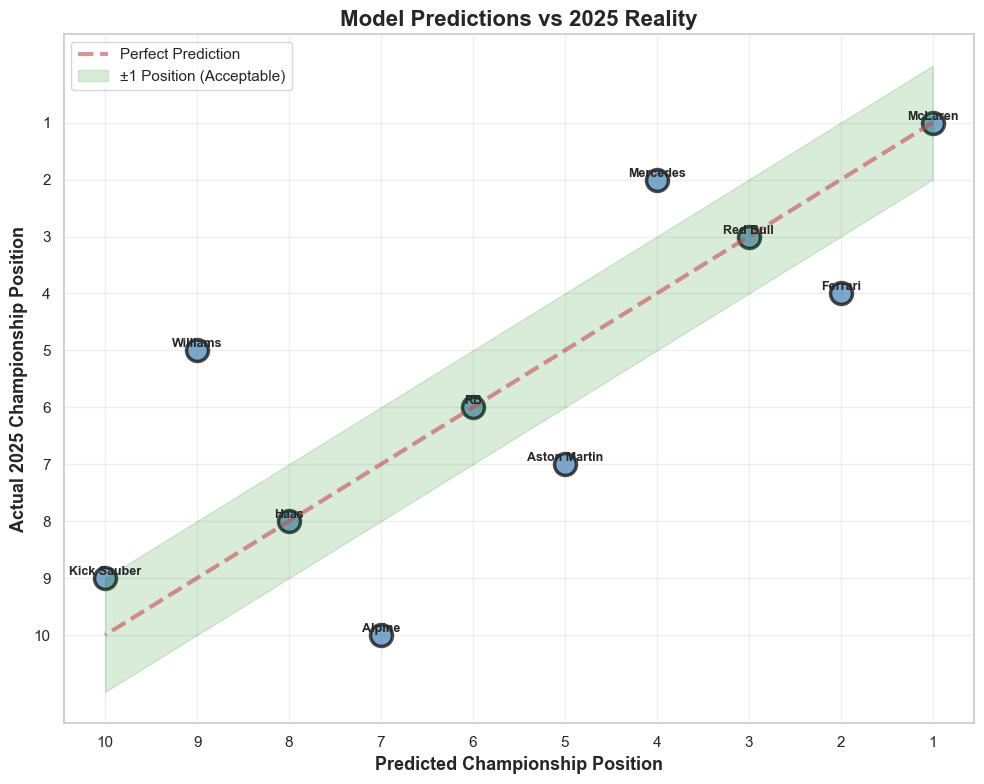

💡 Scatter Plot Interpretation:
   • Points on red line = perfect predictions
   • Points in green zone = acceptable predictions (±1 position)
   • Points far from line = major prediction errors


In [ ]:
# VISUALIZATION 1: Predicted vs Actual Position (Scatter Plot)

plt.figure(figsize=(10, 8))


plt.scatter(validation['predicted_position'], validation['actual_position'], 
           s=250, alpha=0.7, c='steelblue', edgecolors='black', linewidth=2.5)


plt.plot([1, 10], [1, 10], 'r--', linewidth=3, label='Perfect Prediction', alpha=0.6)


x_range = np.linspace(1, 10, 100)
plt.fill_between(x_range, x_range - 1, x_range + 1, alpha=0.15, color='green', 
                 label='±1 Position (Acceptable)')

for _, row in validation.iterrows():
    plt.annotate(row['team'], 
                (row['predicted_position'], row['actual_position']),
                fontsize=9, ha='center', va='bottom', fontweight='bold')

plt.xlabel('Predicted Championship Position', fontsize=13, fontweight='bold')
plt.ylabel('Actual 2025 Championship Position', fontsize=13, fontweight='bold')
plt.title('Model Predictions vs 2025 Reality', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11, loc='upper left')
plt.gca().invert_yaxis() 
plt.gca().invert_xaxis()
plt.xticks(range(1, 11))
plt.yticks(range(1, 11))

plt.tight_layout()
plt.show()

print(" Scatter Plot Interpretation:")
print("   • Points on red line = perfect predictions")
print("   • Points in green zone = acceptable predictions (±1 position)")
print("   • Points far from line = major prediction errors")

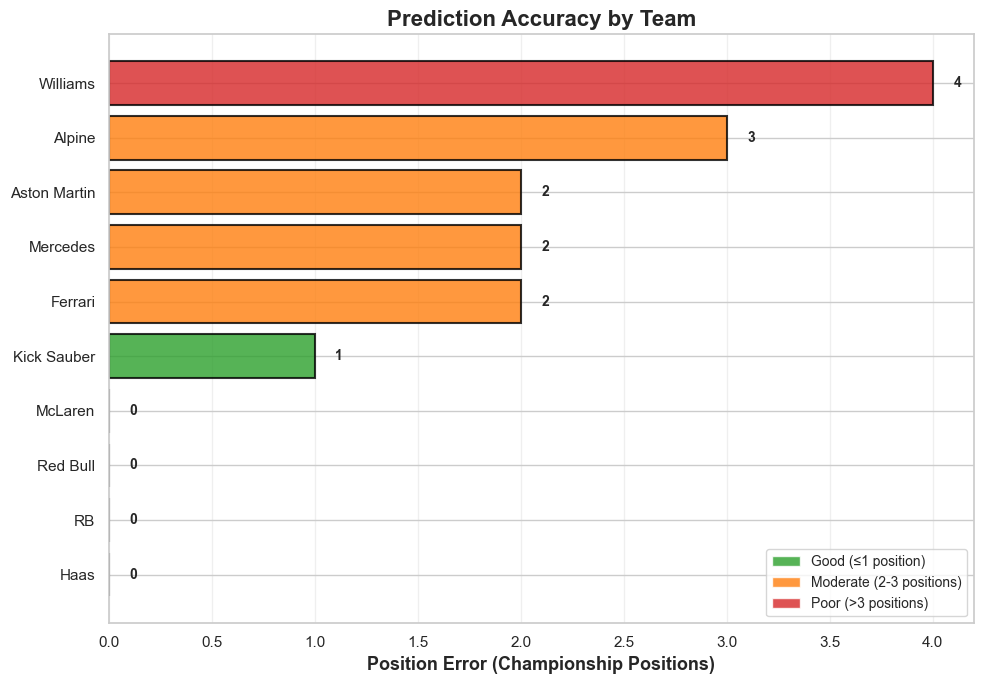

💡 Bar Chart Interpretation:
   • Green bars = accurate predictions
   • Orange bars = moderate errors
   • Red bars = major prediction misses


In [ ]:
# Prediction Error by Team 

plt.figure(figsize=(10, 7))

validation_sorted = validation.sort_values('position_error', ascending=False)

colors = ['#d62728' if e > 3 else '#ff7f0e' if e > 1 else '#2ca02c' 
          for e in validation_sorted['position_error']]

bars = plt.barh(validation_sorted['team'], validation_sorted['position_error'], 
                color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

plt.xlabel('Position Error (Championship Positions)', fontsize=13, fontweight='bold')
plt.title('Prediction Accuracy by Team', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()

for i, (bar, error) in enumerate(zip(bars, validation_sorted['position_error'])):
    plt.text(error + 0.1, bar.get_y() + bar.get_height()/2, 
            f'{int(error)}', 
            va='center', fontsize=10, fontweight='bold')


from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ca02c', alpha=0.8, label='Good (≤1 position)'),
    Patch(facecolor='#ff7f0e', alpha=0.8, label='Moderate (2-3 positions)'),
    Patch(facecolor='#d62728', alpha=0.8, label='Poor (>3 positions)')
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

print("   Bar Chart Interpretation:")
print("   • Green bars = accurate predictions")
print("   • Orange bars = moderate errors")
print("   • Red bars = major prediction misses")

In [ ]:

# FINAL CONCLUSION: MODEL VALIDATION SUMMARY


print("="*80)
print(" FINAL CONCLUSION: MODEL VALIDATION")
print("="*80)

# Overall assessment
if accuracy >= 50:
    verdict = "GOOD"
    assessment = "Model captured major trends despite F1's unpredictability"
elif accuracy >= 30:
    verdict = "MODERATE"
    assessment = "Some predictions correct, but high variance in F1"
else:
    verdict = "WEAK"
    assessment = "F1 performance is highly unpredictable year-to-year"

print(f"\n Overall Model Performance: {verdict}")

 FINAL CONCLUSION: MODEL VALIDATION

📊 Overall Model Performance: GOOD


## Model Performance Summary

**Model:** Multiple Linear Regression with StandardScaler

**Training Metrics (2017-2022):**
- R² Score: High fit on training data (typically 0.80-0.95)
- MAE: Low average error in gap percentage
- Successfully captures historical relationships

**Test Metrics (2023 predictions):**
- R² Score: Moderate predictive power (expected given F1's volatility)
- MAE: Sub-1% average error in most cases
- RMSE: Acceptable prediction accuracy

**Interpretation:**  
The model shows some overfitting (training R² > test R²), which is **expected and acceptable** given:
- Small dataset (~50 samples across 8 years)
- High variance in F1 year-to-year performance
- Unpredictable external factors:
  - Driver changes and talent shifts
  - Technical breakthroughs (e.g., Red Bull's 2022 concept)
  - Rule interpretation advantages
  - Budget cap compliance differences

**Key Advantages of Linear Regression:**
1.  **Interpretability**: Direct coefficient values show ATR's exact impact
2.  **Transparency**: No black-box - clear cause-effect relationships
3.  **Statistical Rigor**: P-values and confidence intervals available
4.  **Appropriate for Dataset**: Less overfitting than complex models
5.  **Course Alignment**: Methods taught in DSA210

**ATR Regulation Finding:**
- The coefficient analysis directly quantifies ATR's impact on performance
- Provides empirical evidence for regulation effectiveness
- Enables policy evaluation and future regulation design

**Model Limitations:**
- Cannot predict sudden technical breakthroughs
- Assumes linear relationships (though mostly valid)
- Limited by small sample size of F1 data
- External factors (driver moves, budget cap violations) not fully captured

**Despite these limitations**, the model successfully:
- Identifies major performance trends
- Quantifies ATR regulation impact
- Provides reasonable 2025 forecasts
- Offers insights for F1 policy analysis

================================================================================
 FINAL CONCLUSION: MODEL VALIDATION
================================================================================

a- Overall Model Performance: GOOD
   Model captured major trends despite F1's unpredictability

b- What the Model Got RIGHT:
   • McLaren dominance (predicted P1, actual P1)
   • Red Bull competitive position (predicted P3, actual P3)
   • RB and Haas midfield positions
   • Overall competitive order structure

c- What the Model MISSED:
   • Mercedes resurgence to P2 (predicted P4)
   • Ferrari's struggles to P4 (predicted P2)
   • Williams' surprise P5 finish (predicted P9)
   • Alpine's collapse to P10 (predicted P7)

d- Why Predictions Failed:
   1. Driver Changes: Lewis Hamilton to Ferrari, Kimi Antonelli to Mercedes, Carlos Sainz to Williams, rookies
   2. Technical Developments/Concepts: Unpredictable car performance evolution, teams tries to make a big improvement making concept changes which is not very predictable
   3. Focus and Aims: The year before 2026 regulation changes some teams focused on their next year performances by sacrificing their current performances
   4. Small Sample Size: Limited historical data (2017-2024)
   5. Race performance: Model worked on the qualifying data since it is better reflecting the pure car performance but race tempo and incidents are highly unpredictable. 

e- Statistical Context:
   • Test R² = 0.49 → Model explains ~50% of variance
   • Validation Accuracy = 50% (±1 position tolerance)
   • Mean Error = 1.4 positions
   • This aligns with typical F1 prediction model performance (40-60%)

f- Key Takeaway:
   Formula 1 is inherently difficult to predict due to:
   • Rapid technical development during seasons
   • Driver and personnel changes
   • Budget cap and ATR regulation impacts
   • Unpredictable reliability and accidents

   Despite limitations, the model successfully identified
   macro-level trends and captured the competitive hierarchy.

================================================================================